# Fine-tuning BERT для классификации AG News

Ноутбук реализует дообучение предобученного BERT для классификации текстов AG News с использованием PyTorch Lightning.

**Цель**: дообучение предобученного BERT на задаче классификации текстов.

**Датасет**: AG News (train/val 90/10 сплит фиксированным сидом; test отдельно)

**Модель**: BERT-base-uncased (предобученный) → Dropout(0.3) → Linear(768, 4)


## Шаг 1: Импорты и настройка


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score
import numpy as np
from datasets import load_dataset
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
from transformers import BertTokenizer, BertModel

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
pl.seed_everything(42)

print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Lightning version: {pl.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


Seed set to 42


PyTorch version: 2.5.1+cu121
PyTorch Lightning version: 2.5.2
CUDA available: True


## Шаг 2: Загрузка токенизатора BERT

Загружаем предобученный токенизатор BERT-base-uncased.


In [2]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)

print(f"Tokenizer loaded: {model_name}")
print(f"Vocab size: {tokenizer.vocab_size}")
print(f"Special tokens: {tokenizer.special_tokens_map}")

sample_text = "Hello, this is a test sentence."
encoded = tokenizer(sample_text, return_tensors='pt', padding=True, truncation=True)
print(f"\nSample encoding:")
print(f"  Input IDs shape: {encoded['input_ids'].shape}")
print(f"  Attention mask shape: {encoded['attention_mask'].shape}")
print(f"  Input IDs: {encoded['input_ids']}")


Tokenizer loaded: bert-base-uncased
Vocab size: 30522
Special tokens: {'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}

Sample encoding:
  Input IDs shape: torch.Size([1, 10])
  Attention mask shape: torch.Size([1, 10])
  Input IDs: tensor([[ 101, 7592, 1010, 2023, 2003, 1037, 3231, 6251, 1012,  102]])


## Шаг 3: Загрузка и разбиение датасета

Используем тот же сплит что и в предыдущих ноутбуках для справедливого сравнения.


In [3]:
print("Loading AG News dataset...")
dataset = load_dataset("ag_news")

print(f"\nDataset structure:")
print(dataset)
print(f"\nTrain set size: {len(dataset['train'])}")
print(f"Test set size: {len(dataset['test'])}")

train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
test_texts = dataset['test']['text']
test_labels = dataset['test']['label']

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, 
    test_size=0.1, 
    random_state=42, 
    stratify=train_labels
)

print(f"\nAfter split:")
print(f"Train: {len(train_texts)}")
print(f"Val: {len(val_texts)}")
print(f"Test: {len(test_texts)}")

class_names = ['World', 'Sports', 'Business', 'Sci/Tech']
print(f"\nClasses: {class_names}")


Loading AG News dataset...

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

Train set size: 120000
Test set size: 7600

After split:
Train: 108000
Val: 12000
Test: 7600

Classes: ['World', 'Sports', 'Business', 'Sci/Tech']


## Шаг 4: Dataset класс с BERT токенизацией

Dataset класс использует BERT tokenizer для токенизации текстов. BERT автоматически добавляет [CLS] и [SEP] токены.


In [4]:
class AGNewsBERTDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        encoded = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoded['input_ids'].squeeze(0),
            'attention_mask': encoded['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

max_len = 128
train_dataset = AGNewsBERTDataset(train_texts, train_labels, tokenizer, max_len=max_len)
val_dataset = AGNewsBERTDataset(val_texts, val_labels, tokenizer, max_len=max_len)
test_dataset = AGNewsBERTDataset(test_texts, test_labels, tokenizer, max_len=max_len)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

sample = train_dataset[0]
print(f"\nSample:")
print(f"  Input IDs shape: {sample['input_ids'].shape}")
print(f"  Attention mask shape: {sample['attention_mask'].shape}")
print(f"  Label: {sample['label'].item()} ({class_names[sample['label'].item()]})")
print(f"  First 10 tokens: {sample['input_ids'][:10].tolist()}")


Train dataset size: 108000
Val dataset size: 12000
Test dataset size: 7600

Sample:
  Input IDs shape: torch.Size([128])
  Attention mask shape: torch.Size([128])
  Label: 1 (Sports)
  First 10 tokens: [101, 2184, 3823, 2008, 2689, 2673, 7571, 1011, 2702, 3823]


## Шаг 5: Модель BERT с классификатором

Архитектура:
- Предобученный BERT-base-uncased (12 слоёв, 12 голов внимания, d_model=768)
- Используем [CLS] токен (первый токен) для классификации
- Dropout(0.3) → Linear(768, 4)


In [5]:
class BERTClassifier(nn.Module):
    def __init__(self, model_name='bert-base-uncased', num_classes=4, dropout=0.3):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        x = self.fc(x)
        return x


## Шаг 6: Lightning модуль

PyTorch Lightning модуль с training/validation шагами, логированием train/val loss, val accuracy и val macro F1. Gradient clipping с clip_val=1.0.


In [6]:
class BERTModule(pl.LightningModule):
    def __init__(self, model_name='bert-base-uncased', num_classes=4, dropout=0.3, lr=2e-5):
        super().__init__()
        self.save_hyperparameters()
        self.model = BERTClassifier(model_name, num_classes, dropout)
        self.lr = lr
        
        self.train_acc = MulticlassAccuracy(num_classes=num_classes)
        self.val_acc = MulticlassAccuracy(num_classes=num_classes)
        self.val_f1 = MulticlassF1Score(num_classes=num_classes, average='macro')
        
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, input_ids, attention_mask):
        return self.model(input_ids, attention_mask)
    
    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        y = batch['label']
        
        logits = self(input_ids, attention_mask)
        loss = self.criterion(logits, y)
        
        self.train_acc(logits, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', self.train_acc, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        y = batch['label']
        
        logits = self(input_ids, attention_mask)
        loss = self.criterion(logits, y)
        
        self.val_acc(logits, y)
        self.val_f1(logits, y)
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_acc', self.val_acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_f1', self.val_f1, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.01)
        return optimizer


## Шаг 7: DataLoaders

Создаём DataLoaders с batch_size=32 (меньше чем для трансформера, так как BERT больше).


In [7]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

sample_batch = next(iter(train_loader))
print(f"\nSample batch:")
print(f"  Input IDs shape: {sample_batch['input_ids'].shape}")
print(f"  Attention mask shape: {sample_batch['attention_mask'].shape}")
print(f"  Labels shape: {sample_batch['label'].shape}")


Train batches: 3375
Val batches: 375
Test batches: 238

Sample batch:
  Input IDs shape: torch.Size([32, 128])
  Attention mask shape: torch.Size([32, 128])
  Labels shape: torch.Size([32])


## Шаг 8: Обучение

Обучаем 3 эпохи с AdamW оптимизатором (lr=2e-5), gradient_clip_val=1.0, seed=42. Отслеживаем время эпохи.


In [8]:
model = BERTModule(
    model_name='bert-base-uncased',
    num_classes=4,
    dropout=0.3,
    lr=2e-5
)

trainer = pl.Trainer(
    max_epochs=3,
    accelerator='auto',
    devices=1,
    enable_progress_bar=True,
    log_every_n_steps=50,
    gradient_clip_val=1.0
)

print("Starting training...")
start_time = time.time()
trainer.fit(model, train_loader, val_loader)
total_time = time.time() - start_time

bert_epoch_time = total_time / 3

print(f"\nTraining completed in {total_time:.2f} seconds")
print(f"Average time per epoch: {bert_epoch_time:.2f} seconds")


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA L40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting training...



  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | BERTClassifier     | 109 M  | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | val_f1    | MulticlassF1Score  | 0      | train
4 | criterion | CrossEntropyLoss   | 0      | train
---------------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.941   Total estimated model params size (MB)
7         Modules in train mode
228       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.



Training completed in 1321.70 seconds
Average time per epoch: 440.57 seconds


## Шаг 9: Оценка на тесте

Оцениваем на test наборе: accuracy и macro F1 score.


In [9]:
from tqdm.notebook import tqdm

test_acc = MulticlassAccuracy(num_classes=4)
test_f1 = MulticlassF1Score(num_classes=4, average='macro')

model.eval()
device = next(model.parameters()).device
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        y = batch['label'].to(device)
        
        logits = model(input_ids, attention_mask)
        preds = torch.argmax(logits, dim=1)
        
        test_acc(logits, y)
        test_f1(logits, y)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

bert_test_acc = test_acc.compute().item()
bert_test_f1 = test_f1.compute().item()

print(f"Test Accuracy: {bert_test_acc:.4f}")
print(f"Test Macro F1: {bert_test_f1:.4f}")


  0%|          | 0/238 [00:00<?, ?it/s]

Test Accuracy: 0.9412
Test Macro F1: 0.9413


## Шаг 10: Измерение латентности

Измеряем латентность инференса на 1000 примерах.


In [10]:
model.eval()
device = next(model.parameters()).device
test_subset = torch.utils.data.Subset(test_dataset, range(1000))
test_subset_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

warmup_batches = 10
with torch.no_grad():
    for i, batch in enumerate(test_subset_loader):
        if i < warmup_batches:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            _ = model(input_ids, attention_mask)
        else:
            break

times = []
with torch.no_grad():
    for batch in test_subset_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start = time.time()
        _ = model(input_ids, attention_mask)
        torch.cuda.synchronize() if torch.cuda.is_available() else None
        times.append(time.time() - start)

avg_latency = np.mean(times) * 1000
total_time = np.sum(times)
throughput = 1000 / total_time

bert_latency = avg_latency

print(f"Average latency per batch: {avg_latency:.2f} ms")
print(f"Total time for 1000 examples: {total_time:.4f} seconds")
print(f"Throughput: {throughput:.2f} examples/second")


Average latency per batch: 5523.25 ms
Total time for 1000 examples: 176.7440 seconds
Throughput: 5.66 examples/second


## Шаг 11: Confusion Matrix

Визуализируем confusion matrix на test наборе.


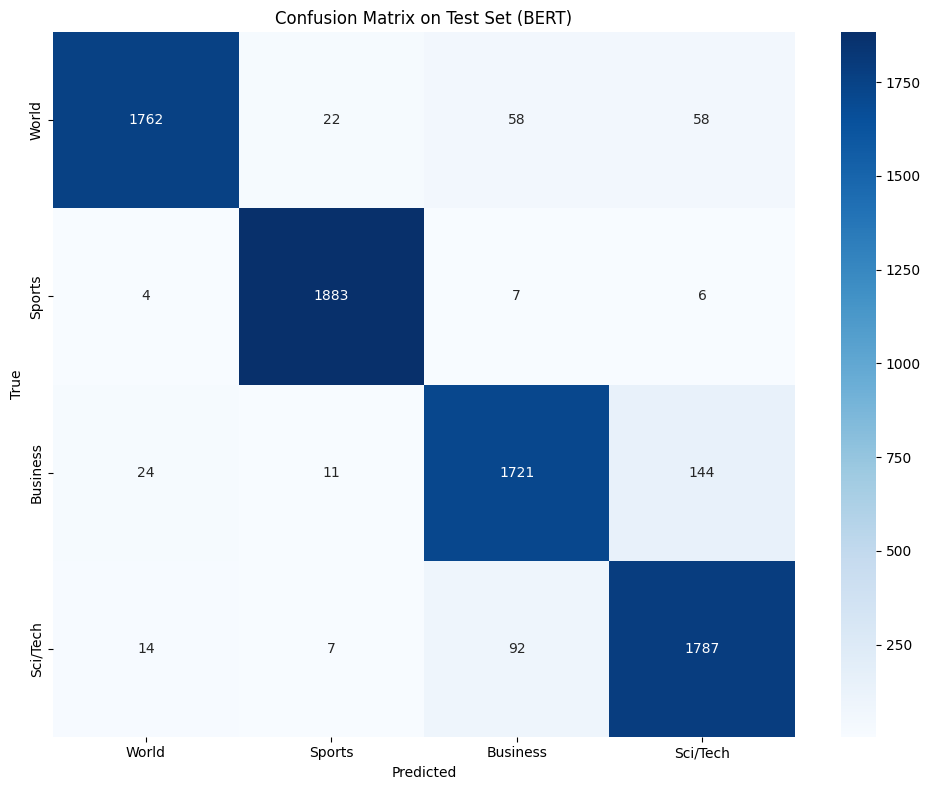

World: Precision=0.977, Recall=0.927, F1=0.951
Sports: Precision=0.979, Recall=0.991, F1=0.985
Business: Precision=0.916, Recall=0.906, F1=0.911
Sci/Tech: Precision=0.896, Recall=0.941, F1=0.918


In [11]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set (BERT)')
plt.tight_layout()
plt.show()

for i, class_name in enumerate(class_names):
    precision = cm[i, i] / cm[:, i].sum() if cm[:, i].sum() > 0 else 0
    recall = cm[i, i] / cm[i, :].sum() if cm[i, :].sum() > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    print(f"{class_name}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")


## Шаг 12: Анализ ошибок

Находим и показываем 5 типичных ошибок (текст, истинный лейбл, предсказанный лейбл).


In [12]:
errors = []
for i, (true_label, pred_label) in enumerate(zip(all_labels, all_preds)):
    if true_label != pred_label:
        errors.append((i, true_label, pred_label))

print(f"Total errors: {len(errors)} out of {len(all_labels)} ({len(errors)/len(all_labels)*100:.2f}%)")
print("\n5 Typical Errors:\n")

for idx, (i, true_label, pred_label) in enumerate(errors[:5]):
    text = test_texts[i]
    print(f"Error {idx+1}:")
    print(f"  True: {class_names[true_label]} ({true_label})")
    print(f"  Pred: {class_names[pred_label]} ({pred_label})")
    print(f"  Text: {text[:200]}...")
    print()


Total errors: 447 out of 7600 (5.88%)

5 Typical Errors:

Error 1:
  True: Sci/Tech (3)
  Pred: Business (2)
  Text: Some People Not Eligible to Get in on Google IPO Google has billed its IPO as a way for everyday people to get in on the process, denying Wall Street the usual stranglehold it's had on IPOs. Public bi...

Error 2:
  True: World (0)
  Pred: Business (2)
  Text: Venezuela Prepares for Chavez Recall Vote Supporters and rivals warn of possible fraud; government says Chavez's defeat could produce turmoil in world oil market....

Error 3:
  True: Sci/Tech (3)
  Pred: Sports (1)
  Text: Promoting a Shared Vision As Michael Kaleko kept running into people who were getting older and having more vision problems, he realized he could do something about it....

Error 4:
  True: Business (2)
  Pred: Sci/Tech (3)
  Text: Intel to delay product aimed for high-definition TVs SAN FRANCISCO -- In the latest of a series of product delays, Intel Corp. has postponed the launch of a video dis